In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
import numpy as np
import tqdm
import matplotlib.pyplot as plt
import pathlib
from sklearn.cluster import KMeans
import xarray as xr

import common.loss_utils as loss_utils
import common.climatehack_dataset as climatehack_dataset 

import sys
sys.path.append('./metnet')
import metnet


In [3]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DEVICE

device(type='cuda')

In [4]:
model = metnet.MetNet2(
        forecast_steps=8,
        input_size=64,
        num_input_timesteps=6,
        upsampler_channels=128,
        lstm_channels=32,
        encoder_channels=64,
        center_crop_size=16,
        ).to(DEVICE)


In [5]:
# MetNet expects original HxW to be 4x the input size
x = torch.randn((2, 6, 12, 256, 256)).to(DEVICE)

In [6]:
out = []
for lead_time in range(8):
    out.append(model(x, lead_time))

/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.79 GiB total capacity; 6.28 GiB already allocated; 11.06 MiB free; 6.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
out = torch.stack(out, dim=1)
y = torch.rand((2,8,12,64,64))
F.mse_loss(out, y).backward()

In [4]:
model = metnet.MetNet(
    hidden_dim=32,
    forecast_steps=24,
    input_channels=1,
    output_channels=1,
    sat_channels=1,
    input_size=32,
)

model = model.to(DEVICE)


In [5]:
# MetNet expects original HxW to be 4x the input size
x = torch.randn((2, 12, 1, 128, 128)).to(DEVICE)

In [8]:
out[0].shape

torch.Size([2, 1, 64, 64])

In [7]:
len(out)

4

In [6]:
out = []
for lead_time in range(24):
    out.append(model(x, lead_time))

/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1795: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


RuntimeError: CUDA out of memory. Tried to allocate 20.00 MiB (GPU 0; 7.79 GiB total capacity; 6.44 GiB already allocated; 11.06 MiB free; 6.45 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [7]:
out = torch.stack(out, dim=1)


In [8]:
out.shape

torch.Size([2, 24, 1, 8, 8])

In [ ]:
out = torch.stack(out, dim=1)
# MetNet creates predictions for the center 1/4th
y = torch.randn((2, 24, 12, 8, 8))
F.mse_loss(out, y).backward()

In [5]:
# model = metnet.MetNet().from_pretrained("openclimatefix/metnet")
# model = metnet.MetNet2().from_pretrained("openclimatefix/metnet-2")

Downloading:   0%|          | 0.00/251 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.40M [00:00<?, ?B/s]

In [9]:
model = model.to(DEVICE)

In [16]:
# MetNet expects original HxW to be 4x the input size
x = torch.randn((2, 12, 12, 1024, 1024)).to(DEVICE)

In [17]:
out = []
for lead_time in range(24):
    out.append(model(x, lead_time))

RuntimeError: CUDA out of memory. Tried to allocate 384.00 MiB (GPU 0; 7.79 GiB total capacity; 6.05 GiB already allocated; 225.62 MiB free; 6.25 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
out = torch.stack(out, dim=1)

In [ ]:
# MetNet expects original HxW to be 4x the input size
x = torch.randn((2, 6, 12, 256, 256))
out = []
for lead_time in range(8):
    out.append(model(x, lead_time))
out = torch.stack(out, dim=1)
y = torch.rand((2,8,12,64,64))
F.mse_loss(out, y).backward()

In [4]:
FORECAST = 24
INPUT_STEPS = 4
BATCH_SIZE = 16

In [5]:
p = pathlib.Path('data/train.npz')
f = np.load(p)
times = f['times']
data = f['data']

In [6]:
times.shape, data.shape

((41896,), (41896, 325, 400))

In [7]:
def check_times(tstart, tend):
    return int((tend - tstart) / np.timedelta64(1, 'm')) == 175

_MEDIAN_PIXEL = 212.0
_IQR = 213.0

def transform(x):
    return np.tanh((x - _MEDIAN_PIXEL) / _IQR)

class CustomTensorDataset(torch.utils.data.Dataset):
    """TensorDataset with support of transforms.
    """
    def __init__(self, times, data, random_state=7):
        self.times = times
        self.data = data
        self.generator = np.random.RandomState(random_state)

    def _get_crop(self, input_slice, target_slice):
        # roughly over the mainland UK
        rand_x = self.generator.randint(0, input_slice.shape[2] - 128)
        rand_y = self.generator.randint(0, input_slice.shape[1] - 128)

        # make a data selection
        in_crop = input_slice[:, rand_y : rand_y + 128, rand_x : rand_x + 128]
        target_crop = target_slice[
            :, rand_y + 32 : rand_y + 96, rand_x + 32 : rand_x + 96
        ]

        return in_crop, target_crop

    def __getitem__(self, index):
        tend = self.times[index + 35]
        tstart = self.times[index]
        if not check_times(tstart, tend):
            return self.__getitem__((index + 35) % len(self))
        src = data[index+12-INPUT_STEPS:index+12]
        trg = data[index+12:index+36]
        x, y = self._get_crop(src, trg)
        x = transform(x)
        y = transform(y)
        return x, y

    def __len__(self):
        return len(self.times) - 35

ds = CustomTensorDataset(times, data)
dl = torch.utils.data.DataLoader(
    ds,
    shuffle=True,
    batch_size=BATCH_SIZE,
    num_workers=4,
    prefetch_factor=4
)


In [8]:
x, y = ds[0]

In [9]:
x.shape, y.shape

((4, 128, 128), (24, 64, 64))

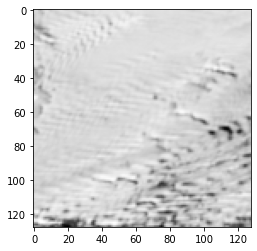

In [10]:
plt.imshow(x[-1], cmap='gray')

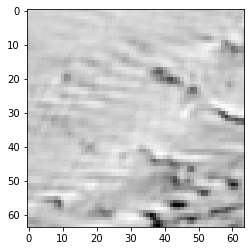

In [11]:
plt.imshow(y[0], cmap='gray')

In [12]:
model = dgmr.DGMR(
    forecast_steps=FORECAST,
    input_channels=1,
    output_shape=128,
    latent_channels=384,
    context_channels=192,
    num_samples=3,
)
model = model.to(DEVICE)
model.load_state_dict(torch.load('weights/300d_dgmr/dgmr_epochs=24_loss=0.0412.pt'))

<All keys matched successfully>

In [13]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model)} trainable parameters')

The model has 58104267 trainable parameters


In [14]:
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mse_criterion = torch.nn.MSELoss()

In [15]:
def train_epoch(model, epoch, dl, optimizer, criterion):
    model.train()
    final_layer = torch.nn.AvgPool2d(kernel_size=2)

    epoch_loss = 0
    total_count = 0
    optimizer.zero_grad()
    pbar = tqdm.tqdm(dl)
    for i, (srcs, trgs) in enumerate(pbar):
        x = srcs.float().to(DEVICE)
        y = trgs.float().to(DEVICE)
        # add a dimension because 1D image
        x = torch.unsqueeze(x, dim=2)
        y = torch.unsqueeze(y, dim=2)

        preds = model(x)
        b, t, c, h, w = preds.shape
        preds = preds.reshape(b, t*c, h, w)
        preds = final_layer(preds)
        preds = preds.reshape(b, t, c, preds.shape[-2], preds.shape[-1])
        preds = torch.tanh(preds)
        loss = criterion(preds, y)
        
#         # put in range [0, 1]. only do this for MS-SSIm
#         preds = (preds + 1)/2
#         y = (y + 1)/2
#         loss = criterion(preds, y).mean()
#         try:
#             loss.backward()
#         except RuntimeError as re:
#             if "Function 'PowBackward1' returned nan values" in str(re):
#                 print('bad grad')
#                 optimizer.zero_grad()
#                 torch.cuda.empty_cache()
#                 continue

        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        ls = loss.item()
        epoch_loss += ls
        total_count += 1
        if i % 1 == 0:
            ls = round(ls, 4)
            avg_loss = round(epoch_loss / total_count, 4)
            pbar.set_description(f'Avg Loss, Batch Loss: {avg_loss, ls}')
            if i % 300 == 299:
                torch.save(model.state_dict(), f'weights/300d_dgmr_full/dgmr_epochs={epoch}_batch={i}_loss={avg_loss}.pt')

    return epoch_loss / total_count




In [16]:
EPOCHS = 100
EXISTING = 0

for i in range(EXISTING + 1, EPOCHS + 1):
    print(f"Epoch {i}")
    avg_loss = train_epoch(model, i, dl, optimizer, mse_criterion)
    avg_loss = round(avg_loss, 4)
    torch.save(model.state_dict(), f'weights/300d_dgmr_full/dgmr_epochs={i}_loss={avg_loss}.pt')


Epoch 1


  0%|          | 0/2617 [00:00<?, ?it/s]/home/sigaida/miniconda3/envs/climatehack/lib/python3.9/site-packages/torch/nn/functional.py:1806: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")
Avg Loss, Batch Loss: (0.0412, 0.0872): 100%|██████████| 2617/2617 [2:04:32<00:00,  2.86s/it]  


Epoch 2


Avg Loss, Batch Loss: (0.0411, 0.1163): 100%|██████████| 2617/2617 [2:04:10<00:00,  2.85s/it]  


Epoch 3


Avg Loss, Batch Loss: (0.0407, 0.0593): 100%|██████████| 2617/2617 [2:04:12<00:00,  2.85s/it]  


Epoch 4


Avg Loss, Batch Loss: (0.0404, 0.0325): 100%|██████████| 2617/2617 [2:04:34<00:00,  2.86s/it]  


Epoch 5


Avg Loss, Batch Loss: (0.0402, 0.0354):  51%|█████     | 1324/2617 [1:02:47<1:01:47,  2.87s/it]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Avg Loss, Batch Loss: (0.0401, 0.0449): 100%|██████████| 2617/2617 [2:04:26<00:00,  2.85s/it]  


Epoch 7


Avg Loss, Batch Loss: (0.0401, 0.0231): 100%|██████████| 2617/2617 [2:04:00<00:00,  2.84s/it]  


Epoch 8


Avg Loss, Batch Loss: (0.0398, 0.0529):  54%|█████▍    | 1413/2617 [1:07:04<57:36,  2.87s/it]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Avg Loss, Batch Loss: (0.0397, 0.0357): 100%|██████████| 2617/2617 [2:04:13<00:00,  2.85s/it]


Epoch 9


Avg Loss, Batch Loss: (0.0396, 0.0404):  64%|██████▍   | 1678/2617 [1:19:32<44:26,  2.84s/it]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

Avg Loss, Batch Loss: (0.0392, 0.0504):  78%|███████▊  | 2048/2617 [1:37:22<27:03,  2.85s/it]


KeyboardInterrupt: 

In [17]:
def get_mssim(y, x, average=True):
    assert len(y.shape) == 5
    if average:
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=y.shape[1])
        return criterion(y, x)
    else:
        scores = []
        criterion = loss_utils.MS_SSIM(data_range=1023.0, size_average=True, win_size=3, channel=1)
        for i in range(y.shape[1]):
            score = criterion(y[:,i:i+1], x[:,i:i+1])
            scores.append(score.item())
        return scores

In [19]:
LOOKS = int(2000/BATCH_SIZE)

In [20]:
final_layer = torch.nn.AvgPool2d(kernel_size=2)
criterion = loss_utils.MS_SSIM(
    data_range=1023.0, size_average=True, win_size=3, channel=24)

scores = []
running_total = 0
running_count = 0
pbar = tqdm.tqdm(dl, total=LOOKS)
for i, (srcs, trgs) in enumerate(pbar):
    if i > LOOKS:
        break
    x = srcs.float().to(DEVICE)
    y = trgs.float().to(DEVICE)
    # add a dimension because 1D image
    x = torch.unsqueeze(x, dim=2)
    y = torch.unsqueeze(y, dim=2)
    
    with torch.no_grad():
        preds = model(x)
        
    b, t, c, h, w = preds.shape
    preds = preds.reshape(b, t*c, h, w)
    preds = final_layer(preds)
    preds = preds.reshape(b, t, c, preds.shape[-2], preds.shape[-1])
    preds = torch.tanh(preds)
    
    y = torch.atanh(y) * _IQR + _MEDIAN_PIXEL
    preds = torch.atanh(preds) * _IQR + _MEDIAN_PIXEL
    score = get_mssim(preds, y, average=False)
    scores.append(score)
    
    running_total += np.mean(score)
    running_count += 1
    
    pbar.set_description(f'Avg Score: {running_total/running_count}')
    

Avg Score: 0.7253703668555883: : 126it [00:50,  2.51it/s]                       


In [21]:
scores = np.array(scores)
scores.mean()

0.7253703668555885

In [22]:
step_dgmr = scores.mean(axis=0)
step_dgmr

array([0.81563373, 0.80397118, 0.78970296, 0.77556396, 0.7623018 ,
       0.75102954, 0.74138259, 0.73318734, 0.72587473, 0.71977699,
       0.71447548, 0.71006481, 0.7062662 , 0.70298939, 0.70038354,
       0.69832984, 0.69651619, 0.6952278 , 0.69461462, 0.6941817 ,
       0.6938223 , 0.69396756, 0.6944816 , 0.69514296])

In [23]:
step = np.array([0.94732114, 0.8874218 , 0.8358762 , 0.79312605, 0.75684718,
       0.7254723 , 0.71111752, 0.69969728, 0.68989919, 0.68185381,
       0.67520599, 0.66936791, 0.66448703, 0.66054242, 0.65703949,
       0.65408842, 0.65171868, 0.6504889 , 0.64866001, 0.64693765,
       0.64587313, 0.6450839 , 0.64387597, 0.64268631])

In [25]:
choice = 4
np.array(step[:choice].tolist() + step_dgmr[choice:].tolist()).mean()

0.7369900903988861

In [26]:
out = preds.detach().cpu().numpy()
true = y.detach().cpu().numpy()

out = np.squeeze(out)
true = np.squeeze(true)

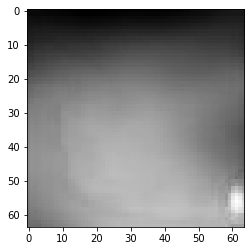

In [31]:
plt.imshow(out[0,-1], cmap='gray')

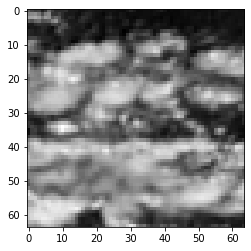

In [32]:
plt.imshow(true[0,-1], cmap='gray')

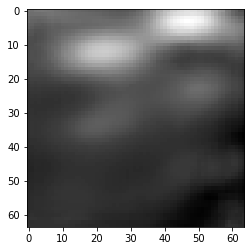

In [29]:
plt.imshow(out[10,0], cmap='gray')

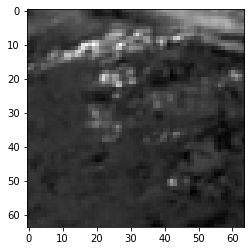

In [30]:
plt.imshow(true[10,0], cmap='gray')